# Recherche Opérationnelle : TP2

# Année 2022-2023 Département Sciences du Numérique. Groupe B2 

## Travail réalisé par Andrei Pakhmutov et Thiago Sotoriva-Lermen

## Questions préliminaires

##### 1) Quelle est la règle de séparation ?
La règle de séparation utilisée est la règle de critère lexicographique, c’est-à-dire que la séparation est effectuée sur le premier objet non encore fixé (dans le sens du parcours des listes définies dans readKnaptxtInstance.

##### 2) Quelle est la méthode du calcul de la borne supérieure ?
Il s'agit d'un calcul de l'optimum avec une relaxation linéaire au préalable (on remplit le sac avec les objets (éventuellement leurs fractions) avec les meilleurs ratios sans que la quantité de chacun dépasse 1 (contrainte d'unicité gardée).

##### 3) Quels sont les tests de sondabilité TA, TO, TR ?
- TA : le test réussit si l'appel termination_status(model) renvoie MOI.INFEASIBLE, ce qui signifie que le problème n'a pas de solutions réalisables.
- T0 : le test réussit si le calcul de la borne supérieure, relative à un noeud donné, avec objective_value(model) renvoie un valeur qui est inférieure à une valeur réalisable déjà connue (BestProfit dans le code).
- TR : le test réussit si la solution optimale, relative à un noeud, est entière (et avec des coefficients tous inférieurs ou égaux à 1 a priori) ; dans le code, on cosidère que c'est le cas si la différence, en valeur absolue, entre les coefficients et leurs arrondis aux entiers les plus proches est inférieure ou égle à 10<sup>-5</sup>

##### 4) Quelle est la stratégie d'exploration ?
La stratégie d’exploration utilisée est la recherche en profondeur en explorant d’abord les
noeuds à gauche, suivis par les noeuds à droite. S’il n’y a pas de noeuds à droite on remonte aux
parents pour reprendre à droite.

## Code et analyse

### Points clés de votre implémentation des différents blocs du Branch-and-Bound
- Règle de séparation :
    - choisir la 1ère variable fractionnaire $solution[k]$ dans l'ordre décroissant du ratio
    - 2 sous-problèmes : $solution[k] = 0$ et $solution[k] = 1$
- TA : réussi si la capacite restante $current\_capacity$ est négative
- TO : réussi si la borne supérieure $cost$ est pire que la meilleure solution connue $BestProfit$ du problème original
- TR : réussi si la solution optimale $solution[k]$ du problème de relaxation courant est entière
- Stratégie d'exploration : Comme dans la solution d'origine, la stratégie d’exploration utilisée est la recherche en profondeur en explorant d’abord les noeuds à gauche, suivis par les noeuds à droite. S’il n’y a pas de noeuds à droite on remonte aux parents pour reprendre à droite.

### Explication du choix de structure de données permettant de garder les informations nécessaires au Branch-and-Bound
- Règle de séparation : Conservation des variables listobjs et listvals (et de leur sémantique) ainsi que l'introduction de plusieurs autres agents auxiliaires, relatifs pour la plupart à un noeud donné, comme :
    - current_price : liste de couples : prix des objets non fixés associés à leurs identifiants
    - current_weight : liste de couples : poids des objets non fixés associés à leurs identifiants
- TA : variable $current\_capacity$ qui contient la capacité relative au noeud sur lequel on se trouve à un instant donné
- TO :
    - variable $cost$ qui contient la valeur de la fonction objective relative au noeud sur lequel on se trouve à un instant donné
    - variable $BestProfit$ qui contient la meilleure solution connue du problème original à un instant donné (initialisée avec -1, pour que les noeuds initiaux ne passent pas le test)
    - la mise à jour par rapport à sa valeur initiale de $BestProfit$ est assurée par TR
- TR : 
    - Étant donnée la stratégie d'exploration de recherche en profondeur, le vecteur-solution du problème $solution$ finira par devenir (pour la première fois) à valeur entière lorsqu'on arrivera à une feuille de l'arbre. C'est alors que la valeur de $BestProfit$ sera mise à jour par rapport à sa valeur initiale.
    - Le test en lui même est basé sur l'évaluation, à chaque noeud, des décalages entre les coefficients effectifs de $solution$ et leurs arrondis aux entiers les plus proches, tous les décalages devant, en valeur absolue, être plus petits que $10^{-5}$. Par aillueurs, on contrôle que les valeurs en questions sont inférieures à $1.0$, ce qui protège l'algorithme des cas où l'on tomberait par hasard sur une valeur entière lors du calcul de la borne supérieure.
- Stratégie d'exploration : Nous avons conservé la stratégie d'exploration de la version d'origine, en adoptant toutefois un point : nous mettons à jour la capacité et le coût intermédiaires à chaque fois qu'on change de noeud. Par ailleurs, à chaque fois que l'on remonte dans l'arbre en suivant une branche droite, on ajoute à $current\_price$ et $current\_weight$ les informations associées aux objets alors libérés, afin de ne pas perdre de données en remontant ainsi.

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:

function TestsSondabilite_relaxation_lineaire(admissible, cost, solutions, BestProfit, Bestsol, affichage_detaille)
    
    TA, TO, TR = false, false, false
    if(!admissible)#Test de faisabilite
        TA=true
        if affichage_detaille
            println("TA")
        end
    elseif(cost <= BestProfit) #Test d'optimalite
        TO=true
        if affichage_detaille
            println("TO")
        end
    elseif( prod(abs.([round.(v, digits=0) for v in solutions]-solutions) .<= fill(10^-5, size(solutions)))
            && prod(v <= 1.0 for v in solutions)) 
        #Test de resolution
        TR=true
        if affichage_detaille
            println("TR")
        end
        #if (value(benef) >= BestProfit)
        if (cost >= BestProfit)
            Bestsol = deepcopy(solutions)
            #BestProfit=value(benef)
            BestProfit= cost
            if affichage_detaille
                println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
            end
        end
    else
        if affichage_detaille
            println("non sondable")
        end
    end
    TA, TO, TR, Bestsol, BestProfit
end

TestsSondabilite_relaxation_lineaire (generic function with 1 method)

### Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:

function SeparerNoeud_relaxation_lineaire(current_price, current_weight, current_capacity, solution_sup_bound, listobjs, listvals, price)
    # This node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left.
    # The separation criteria is to chose the object with the best ratio (among the objects that have not yet been fixed)
    
    nb_obj_rest = length(current_price)

    current_price_val = [current_price[i][1] for i=1:nb_obj_rest]
    
    current_weight_val = [current_weight[i][1] for i=1:nb_obj_rest]
    
    current_list_ind = [current_price[i][2] for i=1:nb_obj_rest]
    
    ratios = current_price_val ./ current_weight_val

    index_max_ratio = findmax(ratios)[2]

    obj = current_list_ind[index_max_ratio]

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,obj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
    
    new_capacity = current_capacity - current_weight_val[index_max_ratio]
    # new_cost = cost + current_price[index_max_ratio]         si on passe en paramètre cost
    fixed_cost = sum([price[listobjs[i]] * listvals[i] for i=1:length(listobjs)])

    deleteat!(current_price, index_max_ratio)
    deleteat!(current_weight, index_max_ratio)

    # return new_capacity, new_cost si on passe en paramètre cost
    return new_capacity, fixed_cost
end


function ExplorerAutreNoeud_relaxation_lineaire(current_price, current_weight, current_capacity, fixed_cost, weight, price, listobjs, listvals, listnodes, affichage_detaille)
    #this node is sondable, go back to parent node then right child if possible
    
    new_capacity = current_capacity
    new_fixed_cost = fixed_cost
    
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)

        
        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            push!(current_price, (price[obj],obj))
            push!(current_weight, (weight[obj],obj))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
            new_capacity = current_capacity + theval*weight[obj]
            new_fixed_cost = fixed_cost - theval*price[obj]
        else
            if affichage_detaille
                println("\nFINISHED")
            end
            stop=true
        end
    else
        #the root node was sondable
        if affichage_detaille
            println("\nFINISHED")
        end
        stop=true
    end
    return stop, new_capacity, new_fixed_cost
end

ExplorerAutreNoeud_relaxation_lineaire (generic function with 1 method)

### Borne supérieure

In [5]:
#Calcul de la borne supérieure et de son coût (relatif à un noeud donné)
function optimizer(borne, current_price, current_weight, current_capacity, n, listobjs, listvals)
    
    nb_obj_rest = length(current_price)

    current_price_val = [current_price[i][1] for i=1:nb_obj_rest]
    
    current_weight_val = [current_weight[i][1] for i=1:nb_obj_rest]
    
    current_list_ind = [current_price[i][2] for i=1:nb_obj_rest]
    
    ratio = current_price_val ./ current_weight_val
    
    stop = false

    indices_ratio = sortperm(ratio, rev = true)
    
    solutions = zeros(n)
    for i=1:n
        if i in listobjs
            ind = findfirst(x->x==i, listobjs)
            if listvals[ind] == 1.0
                solutions[i] = 1.0
            end 
        end
    end
    
    cost = 0
    
    if current_price != []

        if borne == 1
            ind_best_ratio = indices_ratio[1]
            solutions[ind_best_ratio] = current_capacity / current_weight_val[ind_best_ratio]
            cost = cost + solutions[ind_best_ratio] * current_price_val[ind_best_ratio]
        else
            i = 1
            j = current_capacity

            while(!stop)
                indice = indices_ratio[i]
                if (current_weight_val[indice] <= j)
                    solutions[indice] = 1.0
                    cost = cost + current_price_val[indice]
                    j = j - current_weight_val[indice]
                    i = i + 1
                else
                    solutions[indice] = j / current_weight_val[indice]
                    cost = cost + solutions[indice] * current_price_val[indice]
                    j = 0
                    stop = true
                end
                if (i > length(current_price))
                    stop = true
                end
            end
        end
    end
    return cost, solutions
end

optimizer (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [6]:

function SolveKnapInstance(filename, borne)

    price, weight, capacity = readKnaptxtInstance(filename)

    n = length(price)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes = Int64[] #will store orig node of arc in search tree
    trChildnodes = Int64[] #will store destination node of arc in search tree
    trNamenodes = [] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs = [] # list of fixed coefficients
    listvals = [] # list of fixed coeffieicient values 
    listnodes = [] # list of node numbers

    BestProfit = -1 # objective function value evaluated based on the best realizable solution
    Bestsol = [] # best realizable solution
    
    current_price = [(price[i],i) for i=1:n] # list of unfixed coefficient prices
    current_weight = [(weight[i],i) for i=1:n] # list of unfixed coefficient weights
    current_capacity = capacity # remaining capacity

    current_node_number = 0
    stop = false

    fixed_cost = 0.0
    cost = fixed_cost
    
    solution = []
    
    index_separation = 0
    
    affichage_detaille = false
    
    while(!stop)
        
        if affichage_detaille
            println("\nNode number ", current_node_number, ": \n---------------\n")

            print("Max ", price[1], " ", "x[1] ")
            for i=2:n
                print(price[i], " ", "x[", i,"] ")
            end
            println("")
            println("Subject to")

            print(weight[1], "x[1] ")
            for i=2:n
                print(weight[i], "x[", i,"] ")
            end
            println("≤ ", current_capacity)

            for i=1:n
                print("x[", i, "]", " ≥ ")
                if i in listobjs
                    println(listvals[findfirst(x->x==i, listobjs)])
                else
                    println("0.0")
                end
            end

            for i=1:n
                print("x[", i, "]", " ≤ ")
                if i in listobjs
                    println(listvals[findfirst(x->x==i, listobjs)])
                else
                    println("1.0")
                end
            end
        end
        
        
        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes) >= 2)
            push!(trParentnodes,listnodes[end] + 1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number + 1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)
        
        if affichage_detaille
            print("Solve the LP model of the current node to compute its bound: start ... ")
        end
        
        # Call the optimize function
        admissible = (current_capacity >= 0)
        if admissible
            borne_sup_cost, solution = optimizer(borne, current_price, current_weight, current_capacity, n, listobjs, listvals)
            cost = borne_sup_cost + fixed_cost
        else
            if affichage_detaille
                print(" : NOT AVAILABLE (probably infeasible or ressources limit reached)")
            end
        end

        if affichage_detaille
            println("end"); 

            print(": Solution LP ", cost, "     ", "x[1]=", solution[1], "     ")
            for i=2:n
                print("x[",i,"]=",solution[i], "     ")
            end
            println("")

            println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end

        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite_relaxation_lineaire(admissible, cost, solution, BestProfit, Bestsol, affichage_detaille)
        is_node_sondable = TA || TO || TR

        if !is_node_sondable
            current_capacity, fixed_cost = SeparerNoeud_relaxation_lineaire(current_price, current_weight, current_capacity, solution, listobjs, listvals, price)
        else
            stop, current_capacity, fixed_cost = ExplorerAutreNoeud_relaxation_lineaire(current_price, current_weight, current_capacity, fixed_cost, weight, price, listobjs, listvals, listnodes, affichage_detaille)
        end
        
        current_node_number = current_node_number + 1
    end

    return BestProfit, Bestsol, current_node_number, trParentnodes, trChildnodes, trNamenodes

end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final


******

Optimal value = 65.0

Optimal x = [0.0, 1.0, 0.0, 1.0]


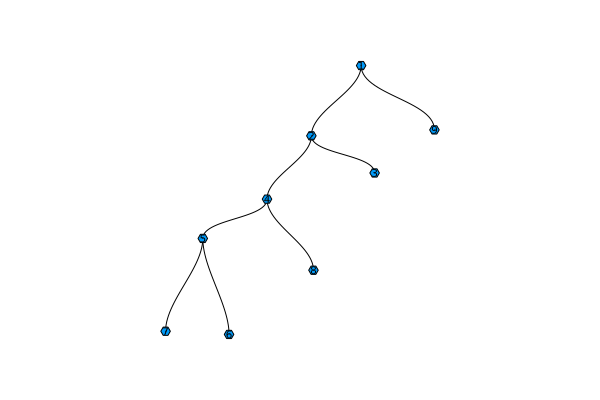

In [10]:
borne = 2
BestProfit, Bestsol, current_node_number, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt", borne)
#BestProfit, Bestsol, current_node_number, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/multiple_strongly_correlated/knapPI_14_20_1000_1_-1794.opb.txt", borne)
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x = ", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)

In [9]:
for (root, dirs, files) in walkdir("instancesETU/KNAPnewformat/test_comparision/")
    
    n = length(files)
    
    @time begin
    
        borne = 1
        sum_prof1 = 0
        for file in files
            _,_,current_node_number,_,_ = SolveKnapInstance(root*file, borne)
            sum_prof1 = sum_prof1 + current_node_number
        end
        prof_moyenne1 = sum_prof1 / n
    
    println("Informations du module time sur la borne 1 : ")
    end
    
    println("Profondeur moyenne pour la borne 1 : ", prof_moyenne1)
    println("")

    @time begin
    
        borne = 2
        sum_prof2 = 0
        for file in files
            _,_,current_node_number,_,_ = SolveKnapInstance(root*file, borne)
            sum_prof2 = sum_prof2 + current_node_number
        end
        prof_moyenne2 = sum_prof2 / n
        
    println("Informations du module time sur la borne 2 : ")
    end
    println("Profondeur moyenne pour la borne 2 : ", prof_moyenne2)
end

Informations du module time sur la borne 1 : 
111.982281 seconds (1.45 G allocations: 31.888 GiB, 15.71% gc time)
Profondeur moyenne pour la borne 1 : 173267.15384615384

Informations du module time sur la borne 2 : 
 90.577891 seconds (1.30 G allocations: 27.759 GiB, 17.50% gc time)
Profondeur moyenne pour la borne 2 : 151327.23076923078


5.
### Interprétation
Nous avons choisi un jeu de tests consititué de 22 fichiers (par 2 dans chaque dossier-type fourni), avec le nombre de variables allant globalement de 20 à 100 et poids, prix et capacités inférieurs à 1000.
Ce choix constitue à notre sens un compromis entre la pertinence des données et le temps d'exécution du programme test ci-dessus.
Nous avons ainsi obtenus les résultats suivants : utiliser la borne 2 plutôt que la 1 permet de gagner en temps d'exécution (environ 15%), en mémoire allouée (environ 10%) et en nombre de noeuds (et donc presque nécessairement en profondeur) de l'arbre engendré (environ 10%).
Remarquons pour commencer que la mémoire allouée est essentiellement proportionnelle au nombre de noeuds. Concentrons-nous donc surtout sur les durées d'exécutions et les nombres de noeuds dans les arbres engendrés.
En somme, les résultats ci-dessus sont cohérents. En effet, par construction, la borne 2, pour un même noeud donné, sera quasi toujours strictement inférieure à la borne 1. Le test de réalisabilité, dans le cas de la borne 2, éliminera donc plus efficacement les sous-arbres et le nombre de noeuds final sera donc plus petit que si l'on utilise la borne 1. Enfin, certes, la borne 2 est légèrement plus complexe à calculer et donc son calcul pur demande plus de temps que celui de la borne 1, mais cela est en pratique largement contrebalancé par la non-nécessité de visiter les noeuds éliminés d'emblée par la borne 2 et laissés par la borne 1. 